# 微调向量模型
开源向量模型通常是在大规模通用语料库上进行预训练的，在单个特定领域中可能无法捕捉句子中的全部语义信息，我们将向量模型在小规模数据集上进行微调可以使模型更好地提取句子中的语义信息，进而提升RAG的检索能力。

## 一、使用Sentence Transformers微调向量模型
`Sentence Transformers`是基于`PyTorch`和`Transformers`的开源框架，在提供了大量句子、文本、图像的向量模型的同时也对向量模型的微调进行了很好的封装。本节中我们将使用此框架微调向量模型。
### 1. 数据集类型以及对应损失函数
我们在微调向量模型时需要读取数据集并根据数据集选择合适的损失函数，`Sentence Transformers`支持下方表格所示四种格式数据集以及对应数据集的损失函数：
|数据集结构 | 损失函数 |
| --- | --- |
|句对样本|MultipleNegativesRankingLoss(多负例排名损失)<br>MegaBatchMarginLoss(超大批次间隔损失)|
|带分数的句对样本|ContrastiveLoss(对比损失)<br>SoftmaxLoss<br>CosineSimilarityLoss(余弦相似度损失)|
|三元组|TripletLoss(三元组损失)|
|带有标签的单句|BatchAllTripletLoss(全批次处理三元组损失)<br>BatchHardTripletLoss(批处理硬三元组损失)<br>BatchHardSoftMarginTripletLoss（批处理软间隔硬三元组损失）<br>BatchSemiHardTripletLoss(批处理半硬三元组损失)|

接下来我们对每种数据集及其对应的损失函数进行介绍。

> 对损失函数不太了解的伙伴可以先看下本章附损失函数浅析，为学习接下来内容做下铺垫。
#### 1.1句对样本
相似的句子对，比如问题-答案、全文-摘要以及意思相同的问题

In [1]:
from datasets import Dataset
sequence = [['Datawhale是什么?','Datawhale是一个专注于数据科学与AI领域的开源组织。'], ['llm_universe是什么?','llm_universe是一个面向小白开发者的大模型应用开发教程。']]

ds = Dataset.from_dict({'sequence': sequence})
print(ds[0])

{'sequence': ['Datawhale是什么?', 'Datawhale是一个专注于数据科学与AI领域的开源组织。']}


句对样本类型的数据在微调向量模型时支持的格式为`Texts: (anchor, positive) pairs`(anchor为第一句为锚定句、参考句，与第二句positive是相似的一组正例)，常用的损失函数有两种：
1. `MultipleNegativesRankingLoss(多负例排名损失)`：该损失函数会把大小为n的批次数据中当前句对样本作为正例，把当前句对样本的`anchor`与当前句对样本外其他样本的`positive`作为反例，通过余弦相似度等相似函数获得它们之间的相似程度，最后将得分与能够指示正例与负例关系的标签传入交叉熵损失函数计算并得到损失。因此该损失函数的性能随着批次的增加而提高。
$$L=-\frac{1}{n}\sum_{i=1}^{n}\bigg[S(x_i,y_i)-log\sum_{j=1}^{n}e^{S(x_i,y_j)}\bigg]$$
其中$n$为批次大小，$x_i$、$y_i$是第$i$个`anchor`与`positive`，S表示将输入的两个句子向量化并计算相似度。实例化时需要提供`model`一个参数，默认的相似函数为余弦相似度，如果使用点积相似度的话需要额外设置`scale=1, similarity_fct=util.dot_score`。

2. `MegaBatchMarginLoss(超大批次间隔损失)`：该损失函数会为批次中每个句对样本的`anchor`从该批次其他句对样本中的`positive`寻找余弦相似度最低的句子作为该句对样本的`negative`，使用该损失函数时建议批次大小为500及以上，最后得到的损失为:
$$L=\frac{1}{n}\sum_{i=1}^{n}[max(0,positive \, margin-cos \, sim(\vec{anchor},\vec{positive}))+max(0,cos \, sim(\vec{anchor},\vec{negative})-negative \, margin)]$$
其中$n$为批次大小，$positive \, margin$为期待微调后`anchor`与`positive`的余弦相似度，$negative \, margin$为期待微调后`anchor`与`negative`的余弦相似度。
实例化该损失函数时，需要提供`model`一个参数，当然我们也可以指定`positive_margin`与`negative_margin`。

#### 1.2 带分数的句对样本
一对句子以及描述他们之间相似程度的标签

In [2]:
premise = ['Datawhale是一个专注于数据科学与AI领域的开源组织。', 'Datawhale是一个专注于数据科学与AI领域的开源组织。', 'Datawhale是一个专注于数据科学与AI领域的开源组织。']
hypothesis = ['我今天很开心！','我参加了Datawhale的组队学习' , 'Datawhale是一个开源组织。']
# 用0,1,2表示句子之间的相似程度, 分别为不相似、部分相似、相似
label = [0, 1, 2]

ds = Dataset.from_dict({'premise': premise, 'hypothesis': hypothesis, 'label': label})
ds[0]

{'premise': 'Datawhale是一个专注于数据科学与AI领域的开源组织。',
 'hypothesis': '我今天很开心！',
 'label': 0}

该类型数据在微调向量模型时要将数据转换为`Sentence Transformers`支持的格式一般为`Texts: (sentence_A, sentence_B) pairs, Labels: class`，常用的损失函数有三种可以选用,但需要的数据格式却有细微的差别:
1. `ContrastiveLoss`(对比损失)：该损失函数适用于数据只有两类的数据集，公式为：
$$L=\frac{1}{n}\sum_{i=1}^{n}\{(1-label_i)\frac{1}{2}(cos \, dis(\vec{sent\_A_i},\vec{sent\_B_i}))^2+(label_i)\frac{1}{2}[max(0,margin-cos \, dis(\vec{sent\_A_i},\vec{sent\_B_i}))]^2\}$$

其中$n$为批次大小，0为不相似，1为相似，$margin$为`label`值为0的句对样本中`sentence_A, sentence_B`的最小距离阈值，$cos \, dis(\vec{a},\vec{b})$表示向量$\vec{a}$与$\vec{b}$的余弦距离。在实例化时至少需要`model`一个参数，除此之外我们还可以指定$margin$或者将余弦距离替换为曼哈顿距离、欧氏距离；

2. `SoftmaxLoss`：该损失函数适用于数据标签为多类的数据集，原理如下图所示通过将sentence_A, sentence_B向量化后得到的u、v以及|u-v|拼接到一起传入Softmax分类器并得到该句对在各类别的概率，最后的损失由交叉熵损失函数计算得出。
<div align="center">
  <img src="./figures/SBERT_SoftmaxLoss.png" alt="SoftmaxLoss" width="400" />
</div>

该损失函数实例化时至少需要`model`需要微调的模型、`sentence_embedding_dimension`模型向量化句子输出的维度以及`num_labels`类别数量三个参数；

3. `CosineSimilarityLoss`(余弦相似度损失)：该损失函数会计算sentence_A, sentence_B向量化后的余弦相似度，并将得到的余弦相似度与`label`值传入平均平方误差损失函数（MSE）得出。其中`Labels`为两个句子的相似度格式为0至1之间的浮点数，实例化时需要`model`一个参数。

#### 1.3 三元组
三元组格式的数据分别为锚定句（anchor）、与锚定句语义相近的正句（positive）以及与锚定句语义相反的反句（negative）

In [3]:
anchor = ['我该怎么学习RAG？', '我要如何养花？']
positive = ['大家是怎么学习RAG的？', '养花时要注意什么？']
negative = ['RAG是什么？', '玫瑰花有多少种？']

ds = Dataset.from_dict({'anchor': anchor, 'positive': positive, 'negative': negative})
print(ds[0])

{'anchor': '我该怎么学习RAG？', 'positive': '大家是怎么学习RAG的？', 'negative': 'RAG是什么？'}


该类型数据在微调向量模型时支持的格式为`Texts: (anchor, positive, negative) triplets`，常用的损失函数为`TripletLoss`(三元组损失)：
$$L=max(||\vec{anc}-\vec{pos}||^2-||\vec{anc}-\vec{neg}||^2+margin,0)$$
其中`margin`是正负距离之间的松弛间隔，$||\vec{a}-\vec{b}||^2$表示向量$\vec{a}$与$\vec{b}$之间的欧氏距离，在实例化时至少需要`model`一个参数，也可以自己设置松弛间隔`margin`。

### 1.4 带有标签的单句
单个句子以及描述单句类别的标签（最少有两种类别且每个标签类最少两个示例）

In [4]:
question = ['Datawhale是什么?', 'llm_universe是什么?', '我今天的早餐是豆浆。', '我好想吃火锅呀！']
# 0:计算机、互联网,1:饮食
label = [0, 0, 1, 1]

ds = Dataset.from_dict({'question': question, 'label': label})
print(ds[0])

{'question': 'Datawhale是什么?', 'label': 0}


该类型数据在微调向量模型时支持的格式为`Texts: single sentences, Labels: class`,常用的损失函数有四种：
1. `BatchAllTripletLoss`(全批次处理三元组损失)：该损失函数将批次单句生成所有可能的三元组，并使用`TripletLoss`计算损失，因此每个批次中数据至少有两类，每类至少有两个示例。在实例化时至少需要`model`一个参数，也可以自己设置松弛间隔`margin`。
2. `BatchHardTripletLoss`(批处理硬三元组损失)：该损失函数只使用每个锚点对应的最远的`positive`与最近的`negative`作为三元组，在实例化时至少需要`model`一个参数，同样可以自己设置松弛间隔`margin`。
3. `BatchHardSoftMarginTripletLoss`(批处理软间隔硬三元组损失)：与`BatchHardTripletLoss`大体相同只不过最后的损失使用对数函数与指数函数计算，所以松弛间隔是软的，不需要人为设置，在实例化时只需要给出`model`参数即可。
4. `BatchSemiHardTripletLoss`(批处理半硬三元组损失)：同样生成三元组并使用`TripletLoss`计算损失，但生成条件需满足`dis(anchor, positive)<dis(anchor, negative) + margin`，在实例化时至少需要`model`一个参数，同样可以自己设置松弛间隔`margin`。

### 2.微调并评估向量模型
大家了解数据集主要类型及损失函数之后我们开始微调向量模型。

In [12]:
# 加载模型
from sentence_transformers import SentenceTransformer
'''
model_name_or_path(模型的名称或者路径):未加载时应为huggingface中的模型，若模型文件在本地则为模型路径
device(设备):选择何种设备进行计算，若未指定则依次检测gpu、mps、npu、cpu
cache_folder(缓存文件夹):模型文件下载地址，也可通过设置环境变量"SENTENCE_TRANSFORMERS_HOME"指定，默认为.cache文件夹
trust_remote_code(信任远程代码):是否信任从远程下载的配置文件
'''
model = SentenceTransformer(model_name_or_path='BAAI/bge-small-zh-v1.5', device='mps', cache_folder='./bge_small', trust_remote_code=True)

/Users/lta/anaconda3/envs/llm_universe_2.x/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# 加载数据集
from datasets import load_dataset

dataset = load_dataset(path='vegaviazhang/Med_QQpairs', cache_dir='./medical')
# 我们可以通过打印 dataset 来了解数据集结构
print(f'最初加载med_dataset结构为:\n{dataset}')
print('med_dataset中训练集结构为:\n{}'.format(dataset['train']))
labels = set()
for i in range(dataset['train'].num_rows): labels.add(dataset['train'][i]['label'])
print(f'med_dataset中标签类别为:\n{labels}')
print('med_dataset训练集中第一条数据为:\n{}'.format(dataset['train'][0]))

最初加载med_dataset结构为:
DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 1000
    })
})
med_dataset中训练集结构为:
Dataset({
    features: ['question1', 'question2', 'label'],
    num_rows: 1000
})
med_dataset中标签类别为:
{0, 1}
med_dataset训练集中第一条数据为:
{'question1': '艾滋患者能用可善挺吗？', 'question2': 'JUNCTURE研究', 'label': 0}


因为`vegaviazhang/Med_QQpairs`数据集是一对句子与描述句子之间相似程度的形式，因此属于上述数据集中第一种情况，又因为标签类别有0、1两种所以我们使用`ContrastiveLoss`损失函数来微调模型。

In [14]:
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses
from sentence_transformers.evaluation import BinaryClassificationEvaluator
# 打乱数据集顺序
dataset = dataset['train'].shuffle(seed=42)
# 将数据集按0.8、0.2的比例分为训练集、验证集并转为实例化 ContrastiveLoss 要求的形式
# 以数据集中第一条数据为例即 texts=['艾滋患者能用可善挺吗？', 'JUNCTURE研究'], label=0
examples = []
for i in range(dataset.num_rows):
  example = dataset[i]
  examples.append(InputExample(texts=[example['question1'], example['question2']], label=example['label']))

train_examples = examples[:800]
dev_examples = examples[800:]

# 将数据集转换为DataLoader形式
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

# 实例化损失函数
train_loss = losses.ContrastiveLoss(model=model)
# 实例化评估器，将每次训练后的模型在验证集上测试性能
evaluator = BinaryClassificationEvaluator.from_input_examples(dev_examples, name='med-dev')
# 定义模型保存路径
model_save_path='./medical_bge_small'
# 微调模型
model.fit([(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=10,
          output_path=model_save_path,
          )

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

因为某些原因无法正常显示，正常运行代码后进度条结果应显示为：
![进度条](./figures/progress_bar.png)

接下来我们读取并绘制模型训练时在验证集上的评估成绩，因为`ContrastiveLoss`计算损失时是基于余弦相似度的所以我们选取与余弦相似度有关的`cossim_accuracy_threshold`数据进行绘制，该指标指的是句对的余弦相似度大于阈值的准确率。
> 注：微调向量模型效果不一定提升，微调对数据集质量与数量都有一定要求，如果数据集相对于模型参数过小则会导致模型出现过拟合的现象。

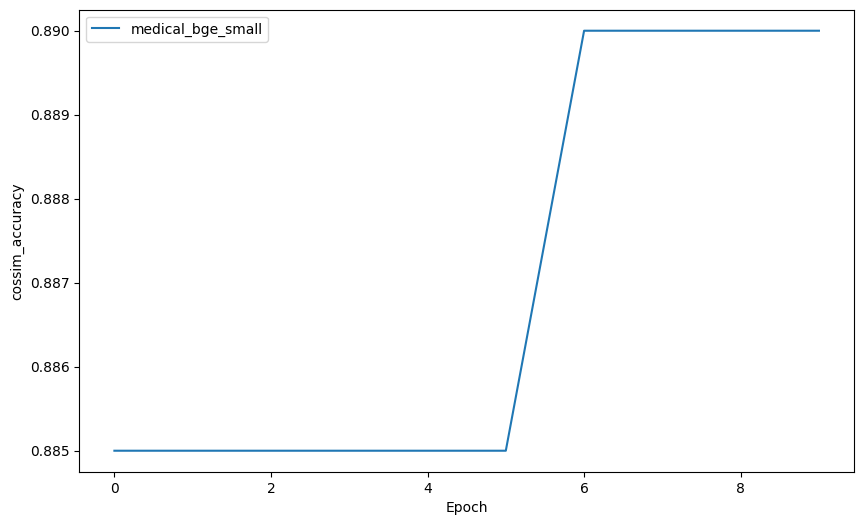

In [17]:
import pandas as pd
from matplotlib import pyplot as plt

eval_small_df = pd.read_csv('./medical_bge_small/eval/binary_classification_evaluation_med-dev_results.csv')
plt.figure(figsize=(10, 6))
plt.plot(eval_small_df['epoch'], eval_small_df['cossim_accuracy'], label='medical_bge_small')
plt.xlabel('Epoch')
plt.ylabel('cossim_accuracy')
plt.legend()
plt.show()

## 二、使用llm构建数据集

网络上很难找到与项目匹配的中文数据集，这种情况下，我们可以借助大语言模型使用项目所涉及的知识构建属于自己的数据集。LangChain虽然在大模型应用开发方面提供了高效的API但是并没有涉及到模型微调，因此在本节我们使用自定义方法借助智谱与OpenAi的大语言模型根据自己的知识库构建数据集。
> 本小节内容参考[LLamaIndex Finetune Embeddings](https://docs.llamaindex.ai/en/stable/examples/finetuning/embeddings/finetune_embedding/)与[langchain.chains.qa_generation.base.QAGenerationChain](https://api.python.langchain.com/en/latest/chains/langchain.chains.qa_generation.base.QAGenerationChain.html#langchain.chains.qa_generation.base.QAGenerationChain)部分内容,并对数据集结构以及大模型调用做了优化。

我们先使用 `PyMuPDFLoader` 加载内容，加载之后的 `pdf_pages`格式为`List[Document]`。每个`Document`都有`page_content`正文以及`metadata`元数据等属性。

In [9]:
from langchain.document_loaders.pdf import PyMuPDFLoader

# 创建一个 PyMuPDFLoader Class 实例，输入为待加载的 pdf 文档路径
loader = PyMuPDFLoader("../../../data_base/knowledge_db/pumkin_book/pumpkin_book.pdf")

# 调用 PyMuPDFLoader Class 的函数 load 对 pdf 文件进行加载
pdf_pages = loader.load()
# 第13页为南瓜书第一页正文，因此从13页开始
train_pages = pdf_pages[13:15]

接下来我们遍历`Document`，对`page_content`进行数据清洗，删除无意义的字符与文字，使数据便于大模型理解。

In [10]:
import re

def clean_text(text: str):
    # 删除每页开头与结尾标语及链接
    text = re.sub(r'→_→\n欢迎去各大电商平台选购纸质版南瓜书《机器学习公式详解》\n←_←', '', text)
    text = re.sub(r'→_→\n配套视频教程：https://www.bilibili.com/video/BV1Mh411e7VU\n←_←', '', text)
    # 删除字符串开头的空格
    text = re.sub(r'\s+', '', text)
    # 删除回车
    text = re.sub(r'\n+', '', text)

    return text

for page in train_pages:
    page.page_content = clean_text(page.page_content)

将清洗好的数据传入`docs_generate_qa_pairs`方法，docs_generate_qa_pairs接收三个参数：
1. docs：格式为`List[Document]`的文档。
2. num_questions_per_page：每页生成的QA对数量，默认为2。
3. moedl：生成QA对所使用的模型，默认为智谱的`glm-4`。


In [11]:
from generate_qa_pairs import docs_generate_qa_pairs

qa_pairs = docs_generate_qa_pairs(docs=train_pages)


100%|██████████| 2/2 [00:46<00:00, 23.31s/it]


返回的结果为`QaPairs`类，我们可以通过调用`QaPairs.qa_pairs`的`'query'`与`'answer'`的返回问题与问题对应的答案。

In [12]:
for i in range(len(qa_pairs.qa_pairs)):
    print('第{}个问题：{}'.format(i + 1, qa_pairs.qa_pairs[i]['query']))
    print('第{}个答案：{}'.format(i + 1, qa_pairs.qa_pairs[i]['answer']), end='\n\n')

第1个问题：请根据提供的上下文信息，解释“特征工程”在机器学习中的作用，并给出一个具体的例子。
第1个答案：显然，用中文书写向量的方式不够“数学”，因此需要将属性值进一步数值化，具体例子参见“西瓜书”第3章3.2。此外，仅靠以上3个特征来刻画西瓜显然不够全面细致，因此还需要扩展更多维度的特征，一般称此类与特征处理相关的工作为“特征工程”。

第2个问题：在机器学习的流程中，为什么要将数据集分为训练集和测试集？这样做有什么好处？
第2个答案：模型：机器学习的一般流程如下：首先收集若干样本（假设此时有100个），然后将其分为训练样本（80个）和测试样本（20个），其中80个训练样本构成的集合称为“训练集”，20个测试样本构成的集合称为“测试集”，接着选用某个机器学习算法，让其在训练集上进行“学习”（或称为“训练”），然后产出得到“模型”（或称为“学习器”），最后用测试集来测试模型的效果。

第3个问题：如何根据标记的取值类型来区分机器学习任务中的“分类”和“回归”任务？请提供原文中相应的定义和标记数值化的例子。
第3个答案：当标记取值为离散型时，称此类任务为“分类”，例如学习西瓜是好瓜还是坏瓜、学习猫的图片是白猫还是黑猫等。当分类的类别只有两个时，称此类任务为“二分类”，通常称其中一个为“正类”，另一个为“反类”或“负类”；当分类的类别超过两个时，称此类任务为“多分类”。由于标记也属于样本的一部分，通常也需要参与运算，因此也需要将其数值化，例如对于二分类任务，通常将正类记为1，反类记为0，即Y={0,1}。这只是一般默认的做法，具体标记该如何数值化可根据具体机器学习算法进行相应地调整，例如第6章的支持向量机算法则采用的是Y={−1,+1}；当标记取值为连续型时，称此类任务为“回归”，例如学习预测西瓜的成熟度、学习预测未来的房价等。由于是连续型，因此标记的所有可能取值无法直接罗列，通常只有取值范围，回归任务的标记取值范围通常是整个实数域R，即Y=R。

第4个问题：在机器学习中，什么是“泛化”能力？请根据原文解释为什么泛化能力是衡量一个模型好坏的关键，并给出相应的例子。
第4个答案：泛化：由于机器学习的目标是根据已知来对未知做出尽可能准确的判断，因此对未知事物判断的准确与否才是衡量一个模型好坏的关键，我们称此为“泛化”能力。例如学习西瓜好坏时，假设训练集中共有3个样本：{

生成的数据可以使用`save_json`来保存为json格式。

In [13]:
qa_pairs.save_json("train_dataset.json")

保存的数据同样可以调用`from_json`方法读取。

In [14]:
from generate_qa_pairs import QaPairs

qa_pairs = QaPairs.from_json('train_dataset.json')

我们可以轻松将生成的qa_pairs转为DataLoader格式，来微调向量模型微调。

In [15]:
# 将单个qa对转为InputExample并存入列表
examples = [InputExample(texts=[qa_pair['query'], qa_pair['answer']]) for qa_pair in qa_pairs.qa_pairs]
# 将数据集转换为DataLoader形式
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

> 问答对生成成功率会受文本内容与num_questions_per_page影响，实测内容为南瓜书、模型为glm-4、num_questions_per_page为1时正确生成给定格式问答对的概率为92.44%，当num_questions_per_page为2时正确生成给定格式问答对的概率降为22.86%。

> 除此之外还有自定义方法`list_generate_qa_pairs`，它与`docs_generate_qa_pairs`除了接受参数格式为`List[str]`之外效果跟`docs_generate_qa_pairs`完全一样，因此也支持从其他方法读取的数据生成问答对。

**参考：**
1. [Hugging Face:Train and Fine-Tune Sentence Transformers Models](https://huggingface.co/blog/how-to-train-sentence-transformers)
2. [Sentence Transformers > Losses](https://sbert.net/docs/package_reference/sentence_transformer/losses.html)